In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Stance Detection for the Fake News Challenge

## Identifying Textual Relationships with Deep Neural Nets

### Check the problem context [here](https://drive.google.com/open?id=1KfWaZyQdGBw8AUTacJ2yY86Yxgw2Xwq0).

### Download files required for the project from [here](https://drive.google.com/open?id=10yf39ifEwVihw4xeJJR60oeFBY30Y5J8).

## Step1: Load the given dataset  

1. Mount the google drive

2. Import Glove embeddings

3. Import the test and train datasets

### Mount the google drive to access required project files

Run the below commands

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#### Path for Project files on google drive

**Note:** You need to change this path according where you have kept the files in google drive. 

In [0]:
import os
project_path = "/content/drive/My Drive/PGPAIML/Sequential NLP/Fake News Challenge/"
os.chdir(project_path)

### Loading the Glove Embeddings

In [0]:
from zipfile import ZipFile
with ZipFile('glove.6B.zip', 'r') as z:
  z.extractall()

# Load the dataset [5 Marks]

1. Using [read_csv()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) in pandas load the given train datasets files **`train_bodies.csv`** and **`train_stances.csv`**

2. Using [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) command in pandas merge the two datasets based on the Body ID. 

Note: Save the final merged dataset in a dataframe with name **`dataset`**.

In [0]:
train_bodies = pd.read_csv("train_bodies.csv")
train_stances = pd.read_csv("train_stances.csv")

In [6]:
print("TRAIN BODIES\n" + '-' * 12)
print("Shape   : {}".format(train_bodies.shape))
print("Columns : [ {} ]".format(", ".join(train_bodies.columns)))
print("")
print("TRAIN STANCES\n" + '-' * 13)
print("Shape   : {}".format(train_stances.shape))
print("Columns : [ {} ]".format(", ".join(train_stances.columns)))

TRAIN BODIES
------------
Shape   : (1683, 2)
Columns : [ Body ID, articleBody ]

TRAIN STANCES
-------------
Shape   : (49972, 3)
Columns : [ Headline, Body ID, Stance ]


In [7]:
dataset = train_bodies.merge(train_stances, on='Body ID')

print("MERGED TRAIN DATA\n" + '-' * 17)
print("Shape   : {}".format(dataset.shape))
print("Columns : [ {} ]".format(", ".join(dataset.columns)))

MERGED TRAIN DATA
-----------------
Shape   : (49972, 4)
Columns : [ Body ID, articleBody, Headline, Stance ]



<h2> Check1:</h2>
  
<h3> You should see the below output if you run `dataset.head()` command as given below </h3>

In [8]:
dataset.head()

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


## Step2: Data Pre-processing and setting some hyper parameters needed for model


#### Run the code given below to set the required parameters.

1. `MAX_SENTS` = Maximum no.of sentences to consider in an article.

2. `MAX_SENT_LENGTH` = Maximum no.of words to consider in a sentence.

3. `MAX_NB_WORDS` = Maximum no.of words in the total vocabualry.

4. `MAX_SENTS_HEADING` = Maximum no.of sentences to consider in a heading of an article.

In [0]:
MAX_NB_WORDS = 20000
MAX_SENTS = 20
MAX_SENTS_HEADING = 1
MAX_SENT_LENGTH = 20
VALIDATION_SPLIT = 0.2

### Download the `Punkt` from nltk using the commands given below. This is for sentence tokenization.

For more info on how to use it, read [this](https://stackoverflow.com/questions/35275001/use-of-punktsentencetokenizer-in-nltk).



In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Tokenizing the text and loading the pre-trained Glove word embeddings for each token  [5 marks] 

Keras provides [Tokenizer API](https://keras.io/preprocessing/text/) for preparing text. Read it before going any further.

#### Import the Tokenizer from keras preprocessing text

In [11]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


#### Initialize the Tokenizer class with maximum vocabulary count as `MAX_NB_WORDS` initialized at the start of step2. 

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

#### Now, using fit_on_texts() from Tokenizer class, lets encode the data 

Note: We need to fit articleBody and Headline also to cover all the words.

In [13]:
texts = []

texts = dataset['articleBody'].tolist() + dataset['Headline'].tolist()
print(len(texts))

tokenizer.fit_on_texts(texts)

99944


#### fit_on_texts() gives the following attributes in the output as given [here](https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/).

* **word_counts:** dictionary mapping words (str) to the number of times they appeared on during fit. Only set after fit_on_texts was called.

* **word_docs:** dictionary mapping words (str) to the number of documents/texts they appeared on during fit. Only set after fit_on_texts was called.

* **word_index:** dictionary mapping words (str) to their rank/index (int). Only set after fit_on_texts was called.

* **document_count:** int. Number of documents (texts/sequences) the tokenizer was trained on. Only set after fit_on_texts or fit_on_sequences was called.



### Now, tokenize the sentences using nltk sent_tokenize() and encode the senteces with the ids we got form the above `t.word_index`

Initialise 2 lists with names `texts` and `articles`.

```
texts = [] to store text of article as it is.

articles = [] split the above text into a list of sentences.
```

In [0]:
article_texts = dataset['articleBody'].tolist()

article_sents = []

for article in article_texts:
  article_sents.append(nltk.sent_tokenize(article))

## Check 2:

first element of texts and articles should be as given below. 

In [15]:
article_texts[0]

'A small meteorite crashed into a wooded area in Nicaragua\'s capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city\'s airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumbe

In [16]:
article_sents[0]

["A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday.",
 "Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports.",
 'Government spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth."',
 'House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports.',
 'Murillo said Nicaragua will ask international experts to help local scientists in understanding what happened.',
 'The crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee.',
 'He said it is still not clear if the meteorite disintegrated or was bu

# Now iterate through each article and each sentence to encode the words into ids using t.word_index  [5 marks] 

Here, to get words from sentence you can use `text_to_word_sequence` from keras preprocessing text.

1. Import text_to_word_sequence

2. Initialize a variable of shape (no.of articles, MAX_SENTS, MAX_SENT_LENGTH) with name `data` with zeros first (you can use numpy [np.zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html) to initialize with all zeros)and then update it while iterating through the words and sentences in each article.

In [0]:
from keras.preprocessing.text import text_to_word_sequence

In [0]:
data = np.zeros((len(article_sents), MAX_SENTS, MAX_SENT_LENGTH),dtype='int32')
for art_idx, article in enumerate(article_sents):
  for sent_idx, sent in enumerate(article):
    if sent_idx > MAX_SENTS-1:
        break
    cur_words = text_to_word_sequence(sent)
    for word_idx, word in enumerate(cur_words):
      if word_idx > MAX_SENT_LENGTH-1:
        break
      data[art_idx][sent_idx][word_idx] = tokenizer.word_index[word]

### Check 3:

Accessing first element in data should give something like given below.

In [19]:
data[0, :, :]

array([[    3,   481,   427,  7211,    81,     3,  3733,   331,     5,
         3891,   350,     4,  1431,  2958,     1,    89,    12,   464,
            0,     0],
       [  758,    95,  1047,     3,  2679,  1752,     7,   189,     3,
         1217,  1075,  2030,   700,   159,     1,  3032,   448,     1,
          555,   235],
       [   89,  1067,  4115,  2349,    12,     3,  1092,  3306,    19,
            1,    89,     2,  1793,     1,   521,  2009,    15,     9,
            3,  3111],
       [  181,  3640,   972,   200,  2556,    44,  6775,  1722,  1252,
            5, 13317, 17936,     1,   778,    31,   740,  3990,    67,
           85,     0],
       [ 2349,    12,  1557,    38,  1094,   351,   775,     2,   367,
          260,  1770,     5,  4450,    70,   494,     0,     0,     0,
            0,     0],
       [    1,   700,   189,    19,     1,   427,    32,     3,  7417,
            4,  2159,  1252,     6,     3,  5270,     4,  1217,  1252,
           12,  3363],
       [  

In [20]:
data.shape

(49972, 20, 20)

# Repeat the same process for the `Headings` as well. Use variables with names `texts_heading` and `articles_heading` accordingly. [5 marks] 

In [0]:
texts_heading = dataset['Headline'].tolist()
articles_heading = []
for headline in texts_heading:
  articles_heading.append(nltk.sent_tokenize(headline))

In [0]:
data_heading = np.zeros((len(texts_heading),MAX_SENTS_HEADING, MAX_SENT_LENGTH),dtype='int32')
for art_idx, article in enumerate(articles_heading):
  for sent_idx, sent in enumerate(article):
    if sent_idx > MAX_SENTS_HEADING-1:
        break
    cur_words = text_to_word_sequence(sent)
    for word_idx, word in enumerate(cur_words):
      if word_idx > MAX_SENT_LENGTH-1:
        break
      data_heading[art_idx][sent_idx][word_idx] = tokenizer.word_index[word]

In [23]:
data_heading.shape

(49972, 1, 20)

### Now the features are ready, lets make the labels ready for the model to process.

### Convert labels into one-hot vectors

You can use [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) in pandas to create one-hot vectors.

In [24]:
labels = pd.get_dummies(dataset['Stance'])
labels.columns

Index(['agree', 'disagree', 'discuss', 'unrelated'], dtype='object')

In [25]:
labels = labels.values
labels.shape

(49972, 4)

### Check 4:

The shape of data and labels shoould match the given below numbers.

In [26]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (49972, 20, 20)
Shape of label tensor: (49972, 4)


### Shuffle the data

In [0]:
## get numbers upto no.of articles
indices = np.arange(data.shape[0])
## shuffle the numbers
np.random.shuffle(indices)

In [0]:
## shuffle the data
data = data[indices]
data_heading = data_heading[indices]
## shuffle the labels according to data
labels = labels[indices]

### Split into train and validation sets. Split the train set 80:20 ratio to get the train and validation sets.


Use the variable names as given below:

x_train, x_val - for body of articles.

x-heading_train, x_heading_val - for heading of articles.

y_train - for training labels.

y_val - for validation labels.



In [29]:
val_split = 0.2
val_size = int(val_split * data.shape[0])
val_size

9994

In [0]:
x_train = data[:-val_size]
x_val = data[-val_size:]
y_train = labels[:-val_size]
y_val = labels[-val_size:]
x_heading_train = data_heading[:-val_size]
x_heading_val = data_heading[-val_size:]

### Check 5:

The shape of x_train, x_val, y_train and y_val should match the below numbers.

In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_heading_train.shape)
print(x_heading_val.shape)

(39978, 20, 20)
(39978, 4)
(9994, 20, 20)
(9994, 4)
(39978, 1, 20)
(9994, 1, 20)


### Create embedding matrix with the glove embeddings


Run the below code to create embedding_matrix which has all the words and their glove embedding if present in glove word list.

In [38]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

vocab_size = len(tokenizer.word_index) + 1
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))


for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


# Try the sequential model approach and report the accuracy score. [10 marks]  

### Import layers from Keras to build the model

In [0]:
from keras.models import Model, Sequential
from keras.layers import Dense, BatchNormalization, Input, Concatenate, concatenate,Activation, Flatten, Dropout, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, merge
from keras.optimizers import SGD

In [34]:
X_train = np.reshape(x_train, (x_train.shape[0], MAX_SENTS * MAX_SENT_LENGTH))
print(X_train.shape)

X_val = np.reshape(x_val, (x_val.shape[0], MAX_SENTS * MAX_SENT_LENGTH))
print(X_val.shape)

print(y_train.shape)
print(y_val.shape)

(39978, 400)
(9994, 400)
(39978, 4)
(9994, 4)


In [35]:
X_heading_train = np.reshape(x_heading_train, (x_heading_train.shape[0], MAX_SENTS_HEADING * MAX_SENT_LENGTH))
print(X_heading_train.shape)

X_heading_val = np.reshape(x_heading_val, (x_heading_val.shape[0], MAX_SENTS_HEADING * MAX_SENT_LENGTH))
print(X_heading_val.shape)

print(y_train.shape)
print(y_val.shape)

(39978, 20)
(9994, 20)
(39978, 4)
(9994, 4)


### Model

In [0]:
input1 = Input(shape=(MAX_SENTS * MAX_SENT_LENGTH, ))
input2 = Input(shape=(MAX_SENTS_HEADING * MAX_SENT_LENGTH, ))
x1 = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix],trainable=False)(input1,)
x2 = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix],trainable=False)(input2,)

x1 = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x1)
x2 = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x2)

x1 = GlobalMaxPool1D()(x1)
x2 = GlobalMaxPool1D()(x2)

x1 = Dense(100, activation="relu")(x1)
x1 = Dropout(0.25)(x1)

x2 = Dense(100, activation="relu")(x2)
x2 = Dropout(0.25)(x2)

x = concatenate([x1, x2])
x = Dense(4, activation="softmax")(x)
model = Model(inputs=[input1,input2], outputs=x)

In [45]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 400, 100)     2787400     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 20, 100)      2787400     input_6[0][0]                    
____________________________________________________________________________________________

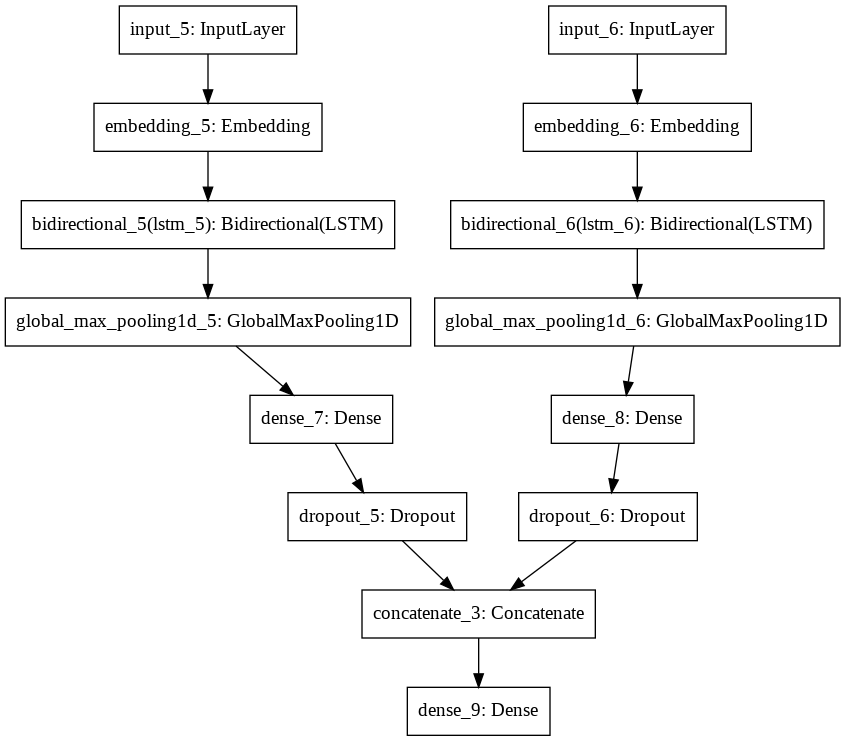

In [46]:
from keras.utils import plot_model 
plot_model(model, to_file='model.png')

### Compile and fit the model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
history = model.fit([X_train,X_heading_train], y_train, batch_size=128, epochs=10, validation_data=([X_val,X_heading_val], y_val))

Train on 39978 samples, validate on 9994 samples
Epoch 1/10
39978/39978 [==============================] - 802s 20ms/step - loss: 0.7626 - acc: 0.7316 - val_loss: 0.7138 - val_acc: 0.7451
Epoch 2/10
39978/39978 [==============================] - 797s 20ms/step - loss: 0.6788 - acc: 0.7492 - val_loss: 0.6511 - val_acc: 0.7734
Epoch 3/10
39978/39978 [==============================] - 796s 20ms/step - loss: 0.6125 - acc: 0.7686 - val_loss: 0.5764 - val_acc: 0.7760
Epoch 4/10
39978/39978 [==============================] - 801s 20ms/step - loss: 0.5619 - acc: 0.7862 - val_loss: 0.5292 - val_acc: 0.7957
Epoch 5/10
39978/39978 [==============================] - 802s 20ms/step - loss: 0.5253 - acc: 0.7998 - val_loss: 0.5015 - val_acc: 0.8144
Epoch 6/10
39978/39978 [==============================] - 801s 20ms/step - loss: 0.5014 - acc: 0.8049 - val_loss: 0.4841 - val_acc: 0.8199
Epoch 7/10
39978/39978 [==============================] - 801s 20ms/step - loss: 0.4778 - acc: 0.8163 - val_loss: 0.4

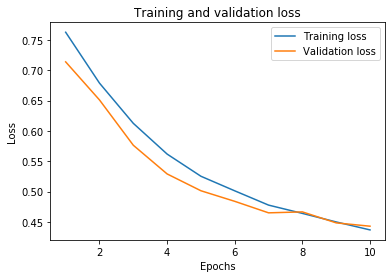

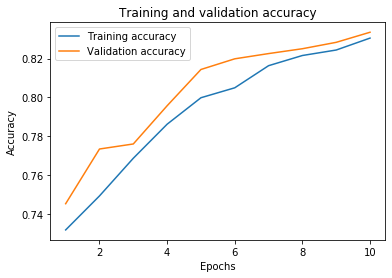

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [57]:
loss,acc = model.evaluate([X_val,X_heading_val],[y_val])
print('Accuracy of the model on validation set is : %s' %(acc))
print('Loss on validation set is : %s' %(loss))

9994/9994 [==============================] - 67s 7ms/step
Accuracy of the model on validation set is : 0.8336001600722015
Loss on validation set is : 0.4431032526784118


## Build the same model with attention layers included for better performance (Optional)

## Fit the model and report the accuracy score for the model with attention layer (Optional)